Consider the standard regression probelem. We have some observed data $\mathcal{D} = [(\mathbf{x}_1, y_1) \dots (\mathbf{x}_n, y_n)]$ with $\mathbf{x} \in \mathbb{R}^D$ and $y \in \mathbb{R}$, and we want to predict the unkown $y_*$ corresponding to some new test point $\mathbf{x}_*$. If we assume the underlying function $y=f(\mathbf{x})$ that generated $\mathcal{D}$ is linear, then we can simply use the least-squares method to draw a line-of-best-fit and thus arrive at our estimate for $y_*$.

Of course the assumption of a linear model will not normally be valid. To lift this restriction, a simple trick is to project the inputs $\mathbf{x} \in \mathcal{R}^D$ into some higher dimensional space $\mathbf{\phi}(\mathbf{x}) \in \mathcal{R}^M$, where $M > D$, and then apply the above linear model in this space rather than on the inputs themselves. For example, a scalar input $x \in \mathcal{R}$ could be projected into the space of powers of $x$: $\phi({x}) = (1, x, x^2, x^3, \dots)^T$. Applying our linear model now on $\phi(x)$ rather than $x$ alone, i.e. $y=f(\phi(x))$, would implicitly perform polynomial regression in the input space.

The above begs the question: How to choose $\phi$?

In the real world our observations are inherently noisy. A common approach to try and model this 

### Bayesian Linear Regression -> GP Regression

The standard Bayesian linear regression model with Gaussian noise is:
$$ f(\mathbf{x}) = \mathbf{x}^T \mathbf{w}, \quad y = f(\mathbf{x}) + \epsilon $$
with
$$ \mathbf{w} \sim \mathcal{N}(0, \Sigma_{p}) \quad \text{and} \quad \epsilon \sim \mathcal{N}(0, \sigma^{2}I) $$

Bay
$$x=\sqrt{a^2 + b^2}$$

In [1]:
from scipy.spatial.distance import pdist, cdist, squareform
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy.optimize import minimize
import warnings

In [2]:
class GPR():
    def __init__(self, kernel, optimizer, noise_var=1e-10):
        self.kernel = kernel
        self.optimizer = optimizer
        self.noise_var = noise_var
        
    def fit(self, X, y, eval_gradient=True):
        pass
    def predict(self, X):
        pass
    def sample_y(self, X, n_samples):
        pass
    def log_marginal_likelihood(self, theta=None, eval_gradient=None):
        pass

In [3]:
class RBF():
    
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds
    
    def __call__(self, X1, X2=None, eval_gradient=False):
        if X2 is None:
            # Upper triangular pair-wise distances
            dists = pdist(X1/self.length_scale, 'sqeuclidean')
            K = np.exp(-0.5 * dists)
            K = squareform(K)  # copy upper-triangle to lower-triangle
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError(
                    "Should only be evaluating gradient when X2 is None.")
            dists = cdist(X1/self.length_scale, X2/self.length_scale, 
                          metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            
        if eval_gradient:
            # Note scipy implementation doesn't divide by self.length_scale but
            # I think this is wrong.
            K_gradient = (K * squareform(dists))[:, :, np.newaxis] / self.length_scale 
            return K, K_gradient
        else:
            return K
    
    def theta(self):
        return np.array([self.length_scale])
    
    def set_theta(self, theta):
        [self.length_scale] = theta
        
    def bounds(self):
        return [self.length_scale_bounds]

In [4]:
def fit(self, X, y, eval_gradient=True):
    
    # demean our observations and take this mean for GP prior 
    # (realized in computing predictive mean eqn. 2.25)
    self._y_train_mean = np.mean(y, axis=0)
    y = y - self._y_train_mean
    
    self.X_train_ = np.copy(X)
    self.y_train_ = np.copy(y)
    self.kernel_ = copy.copy(self.kernel)  # same as prior kernel 
    # but with parameters to be optimized
    
    def obj_func(theta, eval_gradient):
        if eval_gradient:
            lml, grad = self.log_marginal_likelihood(theta, eval_gradient=True)
            return -lml, -grad
        else:
            return -self.log_marginal_likelihood(theta)
    results = minimize(obj_func, 
                       self.kernel_.theta(), 
                       args=(eval_gradient), 
                       method=self.optimizer, 
                       jac=eval_gradient,
                       bounds=self.kernel_.bounds())
    self.log_marginal_likelihood_value = -results['fun']
    self.kernel_.set_theta(results['x'])
    
    # compute alpha of eqn. 2.25, needed for making predictions and computing lml
    K = self.kernel_(self.X_train_)
    K[np.diag_indices_from(K)] += self.noise_var
    try:
        self.L_ = np.linalg.cholesky(K)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix. Try gradually "
                 "increasing the 'alpha' parameter of your "
                    "GaussianProcessRegressor estimator."
                  % self.kernel_,) + e.args
        raise
        
    self.alpha_ = np.linalg.solve(self.L_.T, np.linalg.solve(self.L_, self.y_train_))
    
    return results['success']

GPR.fit = fit

In [5]:
def predict(self, X):
    """ Returns predictive mean and variance."""
    if not hasattr(self, "X_train_"):  # Unfitted; predict based on GP prior.
        y_mean = np.zeros(X.shape[0])
        y_cov = self.kernel(X)
        return y_mean, y_cov
    else:  # Predict based on GP posterior using kernel with optimized params
        K_trans = self.kernel_(X, self.X_train_)
        y_mean = K_trans.dot(self.alpha_)  # Line 4 (y_mean = f_star)
        y_mean = self._y_train_mean + y_mean  # undo normal.

        v = np.linalg.solve(self.L_, K_trans.T)  # self.L_.T * K_inv * K_trans.T
        y_cov = self.kernel_(X) - np.dot(v.T, v)  # Line 6
        
        # Add jitter to avoid numerical issues
        y_cov[np.diag_indices_from(y_cov)] += 1e-10
      
        return y_mean, y_cov
GPR.predict = predict

In [6]:
def sample_y(self, X, n_samples=1):
    y_mean, y_cov = self.predict(X)
    
    # z = np.random.multivariate_normal(y_mean, y_cov, n_samples).T  
    try:
        L = np.linalg.cholesky(y_cov)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix."
                  % self.kernel,) + e.args
        raise
    u = np.random.randn(X.shape[0], n_samples)
    z = np.dot(L, u) + y_mean[:, np.newaxis]
    return z
GPR.sample_y = sample_y

In [7]:
def log_marginal_likelihood(self, theta=None, eval_gradient=False, noise_var=None):
    
    if noise_var is None:
        noise_var = self.noise_var
        
    if theta is None:
        assert hasattr(self, "log_marginal_likelihood_value")
        print('Using fitted theta')
        return self.log_marginal_likelihood_value
    
    kernel = copy.deepcopy(self.kernel)
    kernel.set_theta(theta)
    
    if eval_gradient:
        K, K_gradient = kernel(self.X_train_, eval_gradient=True)
    else:
        K = kernel(self.X_train_)
        
    K[np.diag_indices_from(K)] += noise_var
       
    # Compute L and alpha for this K (theta)
    try:
        L = np.linalg.cholesky(K)
    except np.linalg.LinAlgError:
        return (-np.inf, np.zeros_like(theta)) if eval_gradient else -np.inf

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_train_))
        
    # Compute log-likelihood (eqn. 2.30)
    log_likelihood = -0.5 * np.einsum("i,i", self.y_train_, alpha)
    log_likelihood -= np.log(np.diag(L)).sum()
    log_likelihood -= K.shape[0] / 2 * np.log(2 * np.pi)

    if eval_gradient:
        # Compute lml gradient w.r.t kernel params (eqn. 5.9)
        tmp = np.einsum("i,j->ij", alpha, alpha)
        tmp -= np.linalg.solve(L.T, np.linalg.solve(L, np.eye(K.shape[0])))  # K inverse
        log_likelihood_gradient = 0.5 * np.einsum("ij,ijk->k", tmp, K_gradient)
    
    if eval_gradient:
        return log_likelihood, log_likelihood_gradient
    else:
        return log_likelihood
GPR.log_marginal_likelihood = log_marginal_likelihood

In [8]:
X = np.sort(np.random.uniform(-5, 5, 10))[:, np.newaxis]
kernel = RBF(length_scale=1)
gp = GPR(kernel, 'L-BFGS-B', noise_var=1e-10)

In [9]:
# Sample from prior and take as observations
y_sample = gp.sample_y(X)

In [10]:
y_sample.shape

(10, 1)

In [11]:
%%capture
fig, ax = plt.subplots()

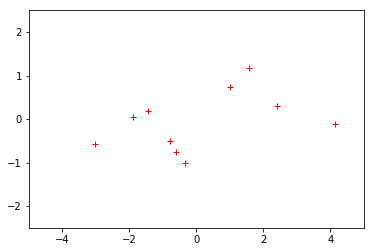

In [12]:
ax.plot(X, y_sample, 'r+')
ax.set_xlim(-5, 5)
ax.set_ylim(-2.5, 2.5)
fig

In [13]:
X_test = np.arange(-5, 5, 0.005)[:, np.newaxis]

In [14]:
gp.fit(X, y_sample[:, 0], True)

True

In [15]:
gp.kernel_.theta()

array([ 0.95045419])

In [16]:
gp.kernel.theta()

array([1])

In [17]:
y_pred_mean, y_pred_covar = gp.predict(X_test)

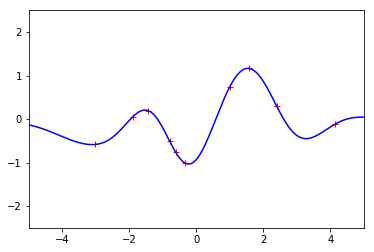

In [18]:
ax.plot(X_test, y_pred_mean, 'b')
fig

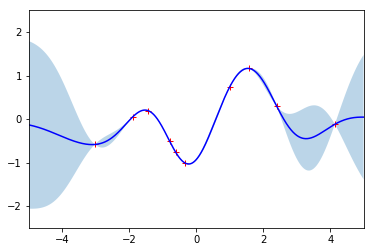

In [19]:
# compute 95% confidence interval from pointwise variances and plot
pointwise_variances = y_pred_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
ax.fill_between(X_test[:, 0], y_pred_mean - error, y_pred_mean + error, alpha=0.3)
fig

In [20]:
y_pred_sample = gp.sample_y(X_test, n_samples=5)

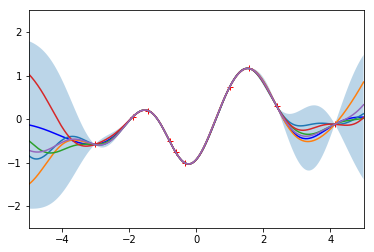

In [21]:
for i in range(y_pred_sample.shape[1]):
    ax.plot(X_test, y_pred_sample[:, i])
fig

In [22]:
gp.log_marginal_likelihood()

Using fitted theta


-2.4264200278080201

In [23]:
# Plot log marginal likelihood w.r.t. different values of theta
length_scales = np.linspace(0.90, 1.2, 100)
noise_variance = np.linspace(1e-11, 1e-4, 100)
X, Y = np.meshgrid(length_scales, noise_variance)

In [24]:
X.shape

(100, 100)

In [25]:
Z = np.array(list(map(lambda x: gp.log_marginal_likelihood(theta=[x[0]], noise_var=x[1]), list(zip(X.ravel(), Y.ravel())))))

In [26]:
Z = Z.reshape((X.shape))

In [27]:
Z.shape

(100, 100)

<a list of 8 text.Text objects>

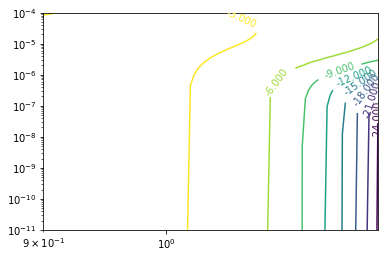

In [28]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
CS = ax.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)